# Downloading Data

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("takihasan/div2k-dataset-for-super-resolution")

print("Path to dataset files:", path)

#path C:\Users\jan\.cache\kagglehub\datasets\takihasan\div2k-dataset-for-super-resolution\versions\1\Dataset

c:\Users\jan\miniconda3\envs\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 4.94G/4.94G [19:01<00:00, 4.65MB/s]

Extracting files...


Path to dataset files: C:\Users\jan\.cache\kagglehub\datasets\takihasan\div2k-dataset-for-super-resolution\versions\1


In [5]:
import os
import glob
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image

# Use the path from the previous cell
dataset_path = r"C:\Users\jan\.cache\kagglehub\datasets\takihasan\div2k-dataset-for-super-resolution\versions\1\Dataset"

class DIV2KDataset(Dataset):
    def __init__(self, root_dir, scale=4, mode='train', crop_size=None, transform=None):
        self.root_dir = root_dir
        self.scale = scale
        self.mode = mode
        self.crop_size = crop_size
        self.transform = transform
        
        if mode == 'train':
            self.hr_dir = os.path.join(root_dir, 'DIV2K_train_HR')
            if scale == 2:
                self.lr_dir = os.path.join(root_dir, 'DIV2K_train_LR_bicubic', 'X2')
            elif scale == 4:
                self.lr_dir = os.path.join(root_dir, 'DIV2K_train_LR_bicubic_X4', 'X4')
            else:
                raise ValueError("Scale must be 2 or 4")
        elif mode == 'valid':
            self.hr_dir = os.path.join(root_dir, 'DIV2K_valid_HR')
            if scale == 2:
                self.lr_dir = os.path.join(root_dir, 'DIV2K_valid_LR_bicubic', 'X2')
            elif scale == 4:
                self.lr_dir = os.path.join(root_dir, 'DIV2K_valid_LR_bicubic_X4', 'X4')
            else:
                raise ValueError("Scale must be 2 or 4")
        else:
            raise ValueError("Mode must be 'train' or 'valid'")
            
        self.hr_files = sorted(glob.glob(os.path.join(self.hr_dir, '*.png')))
        self.lr_files = []
        for hr_path in self.hr_files:
            filename = os.path.basename(hr_path)
            file_id = filename.split('.')[0]
            lr_filename = f"{file_id}x{self.scale}.png"
            self.lr_files.append(os.path.join(self.lr_dir, lr_filename))
        
    def __len__(self):
        return len(self.hr_files)
    
    def __getitem__(self, idx):
        hr_path = self.hr_files[idx]
        lr_path = self.lr_files[idx]
        
        hr_image = Image.open(hr_path).convert('RGB')
        lr_image = Image.open(lr_path).convert('RGB')
        
        if self.crop_size:
            # Random crop
            w, h = lr_image.size
            lr_crop_size = self.crop_size // self.scale
            
            if w < lr_crop_size or h < lr_crop_size:
                 pass
            else:
                i = random.randint(0, h - lr_crop_size)
                j = random.randint(0, w - lr_crop_size)
                
                lr_image = F.crop(lr_image, i, j, lr_crop_size, lr_crop_size)
                hr_image = F.crop(hr_image, i * self.scale, j * self.scale, self.crop_size, self.crop_size)
        
        if self.transform:
            hr_image = self.transform(hr_image)
            lr_image = self.transform(lr_image)
            
        return lr_image, hr_image

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create datasets with cropping for training
# Common crop size for SR is 96x96 (LR) -> 384x384 (HR)
train_dataset = DIV2KDataset(root_dir=dataset_path, scale=4, mode='train', crop_size=192, transform=transform)
valid_dataset = DIV2KDataset(root_dir=dataset_path, scale=4, mode='valid', crop_size=None, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

print(f"Train loader batches: {len(train_loader)}")
print(f"Valid loader batches: {len(valid_loader)}")

# Get a batch
lr_batch, hr_batch = next(iter(train_loader))
print(f"LR Batch shape: {lr_batch.shape}")
print(f"HR Batch shape: {hr_batch.shape}")

Train loader batches: 50
Valid loader batches: 100
LR Batch shape: torch.Size([16, 3, 48, 48])
HR Batch shape: torch.Size([16, 3, 192, 192])
LR Batch shape: torch.Size([16, 3, 48, 48])
HR Batch shape: torch.Size([16, 3, 192, 192])


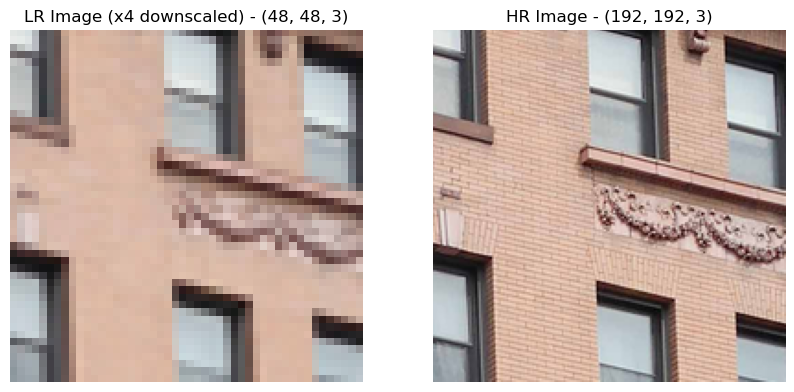

In [6]:
import os
# Fix for potential OpenMP runtime conflict causing kernel crash on Windows
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import matplotlib.pyplot as plt
import numpy as np

def show_images(lr, hr, idx=0):
    plt.figure(figsize=(10, 5))
    
    # LR Image
    plt.subplot(1, 2, 1)
    # Convert from tensor (C, H, W) to numpy (H, W, C)
    lr_img = lr[idx].cpu().permute(1, 2, 0).numpy()
    plt.imshow(lr_img)
    plt.title(f"LR Image (x4 downscaled) - {lr_img.shape}")
    plt.axis('off')
    
    # HR Image
    plt.subplot(1, 2, 2)
    hr_img = hr[idx].cpu().permute(1, 2, 0).numpy()
    plt.imshow(hr_img)
    plt.title(f"HR Image - {hr_img.shape}")
    plt.axis('off')
    
    plt.show()

if 'lr_batch' in locals() and 'hr_batch' in locals():
    show_images(lr_batch, hr_batch, idx=0)
else:
    print("Batches not found. Please run the previous cell to load data.")